In [1]:
#implementation from here: https://github.com/Jeanvit/PySkinDetection


In [2]:
import cv2 
import numpy as np
import matplotlib.pyplot as plt
import numpy.ma as ma


In [3]:
class skinDetector(object):

#class constructor
    def __init__(self, imageName, display_):
        self.image = cv2.imread(imageName)   
        if self.image is None:
            print("IMAGE NOT FOUND")
            exit(1)                          
        #self.image = cv2.resize(self.image,(600,600),cv2.INTER_AREA)
        self.HSV_image = cv2.cvtColor(self.image, cv2.COLOR_BGR2HSV)
        self.YCbCr_image = cv2.cvtColor(self.image, cv2.COLOR_BGR2YCR_CB)
        self.binary_mask_image = self.HSV_image
        self.display = display_
        self.h, self.w = self.image.shape[:2]
        self.total_pixels = self.h * self.w
#================================================================================================================================
    #function to process the image and segment the skin using the HSV and YCbCr colorspaces, followed by the Watershed algorithm
    def find_skin(self):
        self.__color_segmentation()
        #self.__is_mask_balanced()
        #self.__region_based_segmentation()

#================================================================================================================================
#Apply a threshold to an HSV and YCbCr images, the used values were based on current research papers along with some
# empirical tests and visual evaluation
    def __color_segmentation(self):
        lower_HSV_values = np.array([0, 40, 80], dtype = "uint8")
        upper_HSV_values = np.array([25, 255, 255], dtype = "uint8")

        lower_YCbCr_values = np.array((0, 138, 67), dtype = "uint8")
        upper_YCbCr_values = np.array((255, 173, 133), dtype = "uint8")

        #A binary mask is returned. White pixels (255) represent pixels that fall into the upper/lower.
        mask_YCbCr = cv2.inRange(self.YCbCr_image, lower_YCbCr_values, upper_YCbCr_values)
        mask_HSV = cv2.inRange(self.HSV_image, lower_HSV_values, upper_HSV_values) 
        
        cnt_mask_YCbCr = cv2.countNonZero(mask_YCbCr)
        cnt_mask_HSV = cv2.countNonZero(mask_HSV)
        
        
        self.binary_mask_image = cv2.add(mask_HSV,mask_YCbCr)
        cnt_mask_both = cv2.countNonZero(self.binary_mask_image)
        
        cnt_xor = cv2.countNonZero(cv2.bitwise_xor(mask_HSV,mask_YCbCr))
        
        cnt_ratio = cnt_xor / cnt_mask_both
        
        ratio_pixels = cnt_mask_both / self.total_pixels
        
        print("cnt_mask_YCbCr: ", cnt_mask_YCbCr)
        print("cnt_mask_HSV: ", cnt_mask_HSV)
        print("cnt_xor : ", cnt_xor)
        print("cnt_ratio = cnt_xor / cnt_mask_both = :", cnt_ratio)
        
        print("ratio_pixels = cnt_mask_both / self.total_pixels = ", ratio_pixels)
        if self.display:
            plt.figure(0)
            plt.title('YCbCr mask')
            plt.imshow(mask_YCbCr, cmap = 'gray')
            plt.figure(1)
            plt.title('HSV mask')
            plt.imshow(mask_HSV, cmap = 'gray')

           
            plt.figure(2)
            plt.title("Added masks")
            plt.imshow(self.binary_mask_image, cmap = 'gray')

#================================================================================================================================
#Function that applies Watershed and morphological operations on the thresholded image
    def __region_based_segmentation(self):
        #morphological operations
        image_foreground = cv2.erode(self.binary_mask_image,None,iterations = 3)     	#remove noise
        dilated_binary_image = cv2.dilate(self.binary_mask_image,None,iterations = 3)   #The background region is reduced a little because of the dilate operation
        ret,image_background = cv2.threshold(dilated_binary_image,1,128,cv2.THRESH_BINARY)  #set all background regions to 128

        image_marker = cv2.add(image_foreground,image_background)   #add both foreground and backgroud, forming markers. The markers are "seeds" of the future image regions.
        image_marker32 = np.int32(image_marker) #convert to 32SC1 format

        cv2.watershed(self.image,image_marker32)
        m = cv2.convertScaleAbs(image_marker32) #convert back to uint8 

        #bitwise of the mask with the input image
        ret,image_mask = cv2.threshold(m,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
        output = cv2.bitwise_and(self.image,self.image,mask = image_mask)

        if self.display:
        #show the images
            plt.figure(3)
            plt.title('image')
            plt.imshow(self.image[...,::-1])
            plt.figure(4)
            plt.title('mask')
            plt.imshow(image_mask, cmap = 'gray')
            plt.figure(5)
            plt.title('output')
            plt.imshow(output[...,::-1])

#================================================================================================================================
    def is_mask_balanced(self):
        im_lab = cv2.cvtColor(self.image, cv2.COLOR_BGR2LAB)
        
        plt.figure(6)
        plt.title('im_lab')
        plt.imshow(im_lab)
        
        # Calculate the mean values of A and B across all pixels
        means = cv2.mean(im_lab, self.binary_mask_image)
        print("means:", means)
        thresholds = [means[i] - im_lab[:, :, i].std() / 3 for i in range(3)]
        print("thresholds:", thresholds)
        # If mean is below 256 (which is I think the max value for a channel)
        # Apply threshold using only L
        if sum(means[1:]) <= 256:
            mask = cv2.inRange(im_lab, (0, 0, 0), (thresholds[0], 256, 256))
        else:  # Else, also consider B channel
            mask = cv2.inRange(im_lab, (0, 0, 0), (thresholds[0], 256, thresholds[2]))
            
        self.shadow_mask  = cv2.bitwise_and(mask, mask, mask = self.binary_mask_image) 
        cnt_shadow = cv2.countNonZero(self.shadow_mask)
        cnt_skin = cv2.countNonZero(self.binary_mask_image)
        
        if cnt_skin > 0 :
            shadow_ratio = cnt_shadow/cnt_skin
        else :
            shadow_ratio = -1
        
        return shadow_ratio
            
    def show_image(self, image):
        cv2.imshow("Image",image)
        cv2.waitKey(0)
        cv2.destroyWindow("Image")
#================================================================================================================================

In [16]:
im_path = "/home/lattard/PROJECTS/DATA/fingertip/unbalanced.jpg"
im_path = "/home/lattard/PROJECTS/DATA/fingertip/s3_app_data_bad_detections/v16_cropped_fingertips_20200727/TwoFingers_Left_male_adult_white_indoor_adc789750654d2e96cf1dbd9d59b9b6c_06d09f8b-12bc-4ea7-b4b6-7b0b7d345df2_detected_fingertips_1.jpg"
im_path = "/home/lattard/PROJECTS/DATA/fingertip/s3_app_data_bad_detections/Result_1595885260_20200724_181228/Result_1595885260_20200724_181228/Result_1595885260_20200724_181228_108_detected_fingertips_0.jpg"
im_path = "/home/lattard/PROJECTS/DATA/fingertip/s3_app_data_bad_detections/v16_cropped_fingertips_20200727/TwoFingers_Right_male_adult_white_indoor_dbe2a98272d02ac7a097b7c1c8793ead_b649d9a8-6363-41a8-9492-bcf4d010fb52_detected_fingertips_1.jpg"

In [17]:
#%%timeit
detector = skinDetector(im_path, True)


cnt_mask_YCbCr:  212938
cnt_mask_HSV:  61487
cnt_xor :  156147
cnt_ratio = cnt_xor / cnt_mask_both = : 0.7253002982079653
ratio_pixels = cnt_mask_both / self.total_pixels =  0.7025571741854637


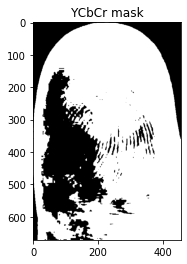

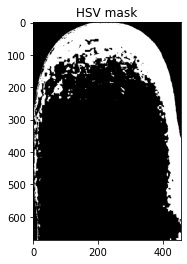

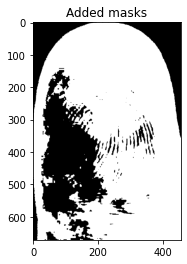

In [18]:
#%%timeit 
detector.find_skin()

means: (145.3575011844709, 159.4599509489702, 138.3076744423697, 0.0)
thresholds: [136.01960378301774, 155.4492411455844, 136.72044615424545]
0.01956931709446968


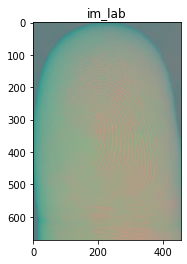

In [19]:
shadow_ratio = detector.is_mask_balanced()
print(shadow_ratio)

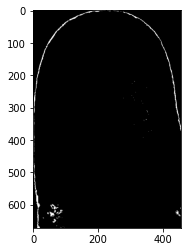

In [20]:
plt.figure(7)
plt.imshow(detector.shadow_mask, cmap = 'gray')

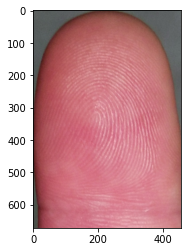

In [21]:
plt.figure(8)
plt.imshow(detector.image[...,::-1])

In [22]:
def is_mask_balanced_by_var(image, mask_):
    # assuming a BGR image, converting to HSV to use the V-channel
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    v = hsv[:, :, 1]
    plt.imshow(v)
    masked_v = ma.masked_array(v, mask=np.logical_not(mask_))
    #plt.imshow(masked_v, cmap ='gray')
    return ma.var(masked_v)

327.19883736337374


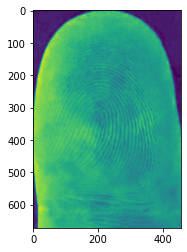

In [23]:
im = cv2.imread(im_path)
balanced = is_mask_balanced_by_var (im, detector.binary_mask_image)
print(balanced)

In [27]:
def measure_contrast(image, mask=None):
    y = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)[:, :, 0]
    #y=image
    if mask is not None:
        masked_y = ma.masked_array(y, mask=np.logical_not(mask))
        return ma.std(masked_y), ma.mean(masked_y)
    else:
        return y.std(), y.mean()

In [30]:
im = cv2.imread(im_path)
#im = np.array([[1,2,1,1],[4,1,1,1]])
#mask = np.array([[1,1,0,0], [1,1,0,0]])
#std, mean = measure_contrast(im, mask=mask)
std, mean = measure_contrast(im, detector.binary_mask_image)
print("mean: ", mean)
print("std: ", std)

mean:  2.0
std:  1.224744871391589


In [26]:
np.array([1,2]).std()

0.5